# Characterizing phase separation: The distribution of the local density

Ralf Everaers, ENS Lyon (2022)

References:

    The gas-liquid transition of the two-dimensional Lennard-Jones fluid, M Rovere, D W Heermann and K Binder, Journal of Physics: Condensed Matter, Volume 2, Number 33 (1990)
    
To track the onset of phase separation below the critical point we are going to observe the distribution of the number of particles in subvolumes of our simulation cell. 

This is an excellent preparation for thinking about the grand-canonical ensemble!

In [2]:
# Import standard libraries
import numpy as np
from scipy.special import gamma
from scipy import sparse
import matplotlib.pyplot as plt
from matplotlib import animation, cm, colors, rc
import random
import time
from imp import reload
rc('animation', html='html5')

# Import library of our own functions
import MPCMolecularDynamics as MD
reload(MD)

#Include plots into notebook instead of plotting them in extra window
%matplotlib inline 

print(np.__version__)

1.20.3


## The routine

is a variant of our MultiParticleCollisionStep, where we already needed to sort particle onto a grid. The sorting is the same, but then all we do is count.

### Test conformation

In [88]:
# define system
NParticles=256
sigma = 1

# density
rho = 0.5/sigma**2
LBox = np.power(NParticles/rho,1/2)
print("LBox = ",LBox)

# define initial state
x = MD.RandomPositions(LBox,NParticles)
y = MD.RandomPositions(LBox,NParticles)

LBox =  22.627416998


### Slow, but readable code

In [89]:
def CellIndices(NCells,x,xBox):
    (xmin, xmax, LBox) = MD.BoxDimensions(xBox)
    return np.floor(NCells*(x-xmin)/LBox).astype(int)

def SortParticlesIntoGrid(NCells,x,y,xBox,yBox,x_pbc=False,y_pbc=False,debug=False):
    
    cells = [[set() for _ in range(NCells)]for _ in range(NCells)] # create list of empty sets #
    nSorted = 0

    (xmin, xmax, LBox) = MD.BoxDimensions(xBox)
    if x_pbc:
        random_box_offset = LBox*np.random.random() # to break Gallilean invariance 
        xmin = random_box_offset 
        xmax = xmin + LBox
        x_sort = MD.FoldIntoBox((xmin,xmax),x) # fold into box / minimum image convention for collisions #
    else:
        x_sort = np.copy(x)
    i = CellIndices(NCells,x_sort,(xmin,xmax))

    (ymin, ymax, LBox) = MD.BoxDimensions(yBox)
    if y_pbc:
        random_box_offset = LBox*np.random.random() # to break Gallilean invariance 
        ymin = random_box_offset 
        ymax = ymin + LBox
        y_sort = MD.FoldIntoBox((ymin,ymax),y) # fold into box / minimum image convention for collisions #
    else:
        y_sort = np.copy(y)
    j = CellIndices(NCells,y_sort,(ymin,ymax))

    for n in range(len(x)):
        if i[n] in range(NCells) and j[n] in range(NCells): 
            cells[i[n]][j[n]].add(n) # add particle index n to the set of particles in cell (i,j) #
            nSorted += 1
    if debug:
        print (nSorted, " of ", len(x)," particles sorted into the grid")
    return cells

In [90]:
SortParticlesIntoGrid(4,x,y,LBox,LBox,x_pbc=False,y_pbc=False,debug=False)

[[{1,
   12,
   28,
   32,
   33,
   56,
   110,
   119,
   143,
   152,
   153,
   180,
   187,
   193,
   196,
   218,
   229,
   252},
  {37,
   81,
   92,
   105,
   129,
   138,
   147,
   156,
   169,
   181,
   183,
   186,
   204,
   227,
   246,
   249},
  {10, 29, 107, 111, 115, 134, 158, 170, 188, 189, 209, 241, 244},
  {7,
   15,
   26,
   27,
   34,
   48,
   80,
   95,
   100,
   127,
   133,
   141,
   166,
   184,
   191,
   201,
   213,
   216,
   231}],
 [{8,
   61,
   71,
   73,
   101,
   106,
   128,
   140,
   151,
   160,
   174,
   194,
   203,
   208,
   219,
   221,
   233,
   242},
  {5,
   24,
   46,
   78,
   99,
   112,
   114,
   116,
   123,
   126,
   139,
   142,
   144,
   148,
   175,
   232,
   234,
   251,
   253},
  {17,
   19,
   23,
   74,
   89,
   91,
   104,
   108,
   118,
   120,
   125,
   130,
   164,
   197,
   202,
   225,
   236,
   243},
  {2, 3, 6, 43, 54, 63, 67, 68, 94, 97, 210, 235, 247, 255}],
 [{14,
   18,
   20,
   22,
   31,
 

The python function len() allows to count the number of elements in a set. To apply it to all elements of my cell table, I convert the latter into a NumPy array and vectorize the len() function:

In [91]:
mylen_vec = np.vectorize(len)

In [92]:
mylen_vec(np.array(SortParticlesIntoGrid(4,x,y,LBox,LBox,x_pbc=False,y_pbc=False,debug=False)))

array([[18, 16, 13, 19],
       [18, 19, 18, 14],
       [18, 16, 13, 17],
       [16, 15, 11, 15]])

Let's make sure, that we have not missed any particles:

In [93]:
np.sum(mylen_vec(np.array(SortParticlesIntoGrid(4,x,y,LBox,LBox,x_pbc=False,y_pbc=False,debug=False))))

256

### Fast code

In [94]:
def CellOccupancy(NCells,xx,yy,xBox,yBox,x_pbc=False,y_pbc=False,debug=False):
    '''
        Returns the occupancy of NCells x NCells cells

        xBox = (xmin,xmax) denotes the simulation box
        xBox = LBox corresponds to a box of (0,LBox)

        if x_pbc==True
            particles are sorted according to their folded positions,
            where the box position is randomly shifted to break Gallilein invariance
        else:
            particles inside the box are sorted according to their absolute positions
    
        the same rules apply in y-direction
    '''
# sort particles into cells
    x = xx.copy()
    if x_pbc:
        x += LBox/NCells*(np.random.random()-0.5) # to break Gallilean invariance #
        x -= np.floor(x/LBox)*LBox # fold into box / minimum image convention for collisions #
    y = yy.copy() 
    if y_pbc:
        y += LBox/NCells*(np.random.random()-0.5) # to break Gallilean invariance #
        y -= np.floor(y/LBox)*LBox
    # cell numbers corresponding to x- and y-coordinates
    i = np.floor(NCells*x/LBox).astype(int)
    j = np.floor(NCells*y/LBox).astype(int)
    # combine into absolute cell number
    row = i + NCells*j
    if debug:
        print("row = ",row)
    # particle numbers
    col = np.array(range(NParticles))
    # combine into projector from particles to cells
    data = np.ones(NParticles)
    sparse_cell_projector = sparse.coo_matrix((data,(row,col)),shape=(NCells**2,NParticles))
    if debug:
        print("projector = ",sparse_cell_projector.todense())
    
    return sparse_cell_projector.A.sum(axis=1)

In [95]:
CellOccupancy(4,x,y,LBox,LBox,x_pbc=False,y_pbc=False,debug=False)

array([ 18.,  18.,  18.,  16.,  16.,  19.,  16.,  15.,  13.,  18.,  13.,
        11.,  19.,  14.,  17.,  15.])

Would be nice to vectorize the function so that it automatically loops over all elements of a trajectory or of an ensemble of trajectories.

In [49]:
CellOccupancy_vec = np.vectorize(CellOccupancy, 
                                 excluded=['NCells','xBox','yBox','x_pbc','y_pbc','debug'],
                                 signature='(j),(j)->(i)')

TypeError: __init__() got an unexpected keyword argument 'signature'

In [1]:
print(np.__version__)

NameError: name 'np' is not defined

Need to update my python installation!

Vectorize by hand: 

means that I automatically loop over all elements of a trajectory or of an ensemble of trajectories.

In [96]:
def CellOccupancy_vec(NCells,xx,yy,xBox,yBox,x_pbc=False,y_pbc=False,debug=False):
    
    
    if xx.ndim==1:
        nOcc = CellOccupancy(NCells,xx,yy,xBox,yBox,x_pbc,y_pbc,debug)
    elif xx.ndim==2:
        # trajectory
        nOcc = []
        for i in range(xx.shape[0]):
            nOcc.append(CellOccupancy(NCells,xx[i],yy[i],xBox,yBox,x_pbc,y_pbc,debug))
    elif xx.ndim==3:
        # trajectory
        nOcc = []
        for i in range(xx.shape[0]):
            nOcc_tr = []
            for j in range(xx.shape[1]):
                nOcc_tr.append(CellOccupancy(NCells,xx[i,j],yy[i,j],xBox,yBox,x_pbc,y_pbc,debug))
            nOcc.append(nOcc_tr)
    else:
        print("CellOccupancy_vec not defined beyond the ensemble level")
    return np.array(nOcc)

In [121]:
# define initial state
x = MD.RandomPositions(LBox,NParticles)
y = MD.RandomPositions(LBox,NParticles)

x_tr = np.array([x,x,x])
y_tr = np.array([y,y,y])

x_tr_ens = np.array([x_tr,x_tr])
y_tr_ens = np.array([y_tr,y_tr])

In [98]:
cOcc = CellOccupancy_vec(4,x,y,LBox,LBox,x_pbc=False,y_pbc=False,debug=False)
print(cOcc.shape)
cOcc

(16,)


array([ 18.,  18.,  18.,  16.,  16.,  19.,  16.,  15.,  13.,  18.,  13.,
        11.,  19.,  14.,  17.,  15.])

In [99]:
cOcc = CellOccupancy_vec(4,x_tr,y_tr,LBox,LBox,x_pbc=False,y_pbc=False,debug=False)
print(cOcc.shape)
cOcc

(3, 16)


array([[ 18.,  18.,  18.,  16.,  16.,  19.,  16.,  15.,  13.,  18.,  13.,
         11.,  19.,  14.,  17.,  15.],
       [ 18.,  18.,  18.,  16.,  16.,  19.,  16.,  15.,  13.,  18.,  13.,
         11.,  19.,  14.,  17.,  15.],
       [ 18.,  18.,  18.,  16.,  16.,  19.,  16.,  15.,  13.,  18.,  13.,
         11.,  19.,  14.,  17.,  15.]])

In [100]:
cOcc = CellOccupancy_vec(4,x_tr_ens,y_tr_ens,LBox,LBox,x_pbc=False,y_pbc=False,debug=False)
print(cOcc.shape)
cOcc

(2, 3, 16)


array([[[ 18.,  18.,  18.,  16.,  16.,  19.,  16.,  15.,  13.,  18.,  13.,
          11.,  19.,  14.,  17.,  15.],
        [ 18.,  18.,  18.,  16.,  16.,  19.,  16.,  15.,  13.,  18.,  13.,
          11.,  19.,  14.,  17.,  15.],
        [ 18.,  18.,  18.,  16.,  16.,  19.,  16.,  15.,  13.,  18.,  13.,
          11.,  19.,  14.,  17.,  15.]],

       [[ 18.,  18.,  18.,  16.,  16.,  19.,  16.,  15.,  13.,  18.,  13.,
          11.,  19.,  14.,  17.,  15.],
        [ 18.,  18.,  18.,  16.,  16.,  19.,  16.,  15.,  13.,  18.,  13.,
          11.,  19.,  14.,  17.,  15.],
        [ 18.,  18.,  18.,  16.,  16.,  19.,  16.,  15.,  13.,  18.,  13.,
          11.,  19.,  14.,  17.,  15.]]])

Now integrate everything into one function.

As a little plus, this version also works for asymmetric box shapes.

In [119]:
def CellOccupancy(NCells,xx,yy,xBox,yBox,x_pbc=False,y_pbc=False,debug=False):
    '''
        Returns the occupancy of NCells x NCells cells

        xBox = (xmin,xmax) denotes the simulation box
        xBox = LBox corresponds to a box of (0,LBox)

        if x_pbc==True
            particles are sorted according to their folded positions,
            where the box position is randomly shifted to break Gallilein invariance
        else:
            particles inside the box are sorted according to their absolute positions
    
        the same rules apply in y-direction
        
        The function can be applied to individual conformations, trajectories and ensembles
            and returns correspondingly shaped arrays
    '''
    
    def individualCellOccupancy(NCells,xx,yy,xBox,yBox,x_pbc=False,y_pbc=False,debug=False):
        # sort particles into cells

        #Keep cells approximately square
        (xmin, xmax, XBox) = MD.BoxDimensions(xBox)
        (ymin, ymax, YBox) = MD.BoxDimensions(yBox)
    
        LBox = np.sqrt(XBox*YBox)
        NCellsX = np.int(np.round(NCells*XBox/LBox))
        NCellsY = np.int(np.round(NCells*YBox/LBox))
    
        NParticles = len(xx)
        # sort particles into cells
        x = xx.copy()
        if x_pbc:
            x += XBox/NCellsX*(np.random.random()-0.5) # to break Gallilean invariance #
            x -= np.floor(x/XBox)*XBox # fold into box / minimum image convention for collisions #
        y = yy.copy() 
        if y_pbc:
            y += YBox/NCellsY*(np.random.random()-0.5) # to break Gallilean invariance #
            y -= np.floor(y/YBox)*YBox
        # cell numbers corresponding to x- and y-coordinates
        i = np.floor(NCellsX*x/XBox).astype(int)
        j = np.floor(NCellsY*y/YBox).astype(int)
        # combine into absolute cell number
        row = i + NCellsX*j
        if debug:
            print("row = ",row)
        # particle numbers
        col = np.array(range(NParticles))
        # combine into projector from particles to cells
        data = np.ones(NParticles)
        sparse_cell_projector = sparse.coo_matrix((data,(row,col)),shape=(NCellsX*NCellsY,NParticles))
        if debug:
            print("projector = ",sparse_cell_projector.todense())
        
        return sparse_cell_projector.A.sum(axis=1) 

    
    # vectorize application of individualCellOccupancy
    if xx.ndim==1:
        nOcc = individualCellOccupancy(NCells,xx,yy,xBox,yBox,x_pbc,y_pbc,debug)
    elif xx.ndim==2:
        # trajectory
        nOcc = []
        for i in range(xx.shape[0]):
            nOcc.append(individualCellOccupancy(NCells,xx[i],yy[i],xBox,yBox,x_pbc,y_pbc,debug))
    elif xx.ndim==3:
        # trajectory
        nOcc = []
        for i in range(xx.shape[0]):
            nOcc_tr = []
            for j in range(xx.shape[1]):
                nOcc_tr.append(individualCellOccupancy(NCells,xx[i,j],yy[i,j],xBox,yBox,x_pbc,y_pbc,debug))
            nOcc.append(nOcc_tr)
    else:
        print("CellOccupancy_vec not defined beyond the ensemble level")
    return np.array(nOcc)

In [122]:
cOcc = CellOccupancy(4,x,y,LBox,LBox,x_pbc=False,y_pbc=False,debug=False)
print(cOcc.shape)
cOcc

(16,)


array([ 11.,  20.,  22.,  17.,  20.,  23.,  22.,  15.,  15.,  19.,  10.,
        13.,  13.,   7.,  14.,  15.])

In [123]:
cOcc = CellOccupancy(4,x_tr,y_tr,LBox,LBox,x_pbc=False,y_pbc=False,debug=False)
print(cOcc.shape)
cOcc

(3, 16)


array([[ 11.,  20.,  22.,  17.,  20.,  23.,  22.,  15.,  15.,  19.,  10.,
         13.,  13.,   7.,  14.,  15.],
       [ 11.,  20.,  22.,  17.,  20.,  23.,  22.,  15.,  15.,  19.,  10.,
         13.,  13.,   7.,  14.,  15.],
       [ 11.,  20.,  22.,  17.,  20.,  23.,  22.,  15.,  15.,  19.,  10.,
         13.,  13.,   7.,  14.,  15.]])

In [124]:
cOcc = CellOccupancy(4,x_tr_ens,y_tr_ens,LBox,LBox,x_pbc=False,y_pbc=False,debug=False)
print(cOcc.shape)
cOcc

(2, 3, 16)


array([[[ 11.,  20.,  22.,  17.,  20.,  23.,  22.,  15.,  15.,  19.,  10.,
          13.,  13.,   7.,  14.,  15.],
        [ 11.,  20.,  22.,  17.,  20.,  23.,  22.,  15.,  15.,  19.,  10.,
          13.,  13.,   7.,  14.,  15.],
        [ 11.,  20.,  22.,  17.,  20.,  23.,  22.,  15.,  15.,  19.,  10.,
          13.,  13.,   7.,  14.,  15.]],

       [[ 11.,  20.,  22.,  17.,  20.,  23.,  22.,  15.,  15.,  19.,  10.,
          13.,  13.,   7.,  14.,  15.],
        [ 11.,  20.,  22.,  17.,  20.,  23.,  22.,  15.,  15.,  19.,  10.,
          13.,  13.,   7.,  14.,  15.],
        [ 11.,  20.,  22.,  17.,  20.,  23.,  22.,  15.,  15.,  19.,  10.,
          13.,  13.,   7.,  14.,  15.]]])

## The structure of an ideal gas

Now test this for an ideal gas "trajectory". 

In [106]:
# define system
NParticles=256
kT = 1
m = np.ones(NParticles)
sigma = 1
epsilon = 1
#unit of time
tau = sigma*np.sqrt(m[0]/epsilon)      

# density
rho = 0.5/sigma**3
LBox = np.power(NParticles/rho,1/2)
print("LBox = ",LBox)

# number of "time steps"
NSteps = 100

x_tr = []
y_tr = []

# define initial state
for n in range(NSteps):
    x_tr.append(MD.RandomPositions(LBox,NParticles))
    y_tr.append(MD.RandomPositions(LBox,NParticles))

x_tr = np.array(x_tr)
y_tr = np.array(y_tr)

nOcc_tr = CellOccupancy(4,x_tr,y_tr,LBox,LBox,x_pbc=False,y_pbc=False,debug=False)

LBox =  22.627416998


In [107]:
nOcc_hist, nOcc_bin_edges = np.histogram(nOcc_tr, 101, (-0.5,100.5), normed=None, weights=None, density=True)

Text(0, 0.5, 'p(n)')

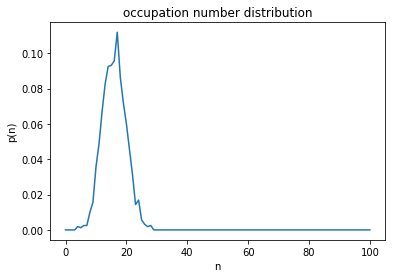

In [108]:
plt.plot(MD.BinCenters(nOcc_bin_edges),nOcc_hist)
plt.title("occupation number distribution")
plt.xlabel("n")
plt.ylabel("p(n)")

In [109]:
np.sum(nOcc_hist)

1.0

The pair correlation function reveals, that there is no structure.

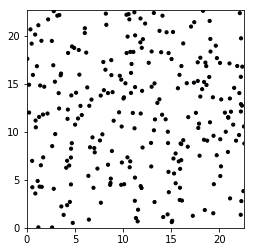

In [110]:
MD.PlotMDConf(x_tr[-1],y_tr[-1],xBox=(0,LBox),yBox=(0,LBox),xpbc=True,ypbc=True,m=m)

## The structure of a T=0 crystalline solid

As an example for a crystalline solid we can choose the grid configurations we designed as initial states.

In [111]:
# define system
NParticles=256
kT = 1
m = np.ones(NParticles)
sigma = 1
epsilon = 1
#unit of time
tau = sigma*np.sqrt(m[0]/epsilon)      

# density
rho = 0.5/sigma**3
LBox = np.power(NParticles/rho,1/2)
print("LBox = ",LBox)

# number of "time steps"
NSteps = 100

x_tr = []
y_tr = []

# define initial state
for n in range(NSteps):
    x,y = MD.GridPositionsIn2d(LBox,LBox,NParticles)
    x_tr.append(x)
    y_tr.append(y)

x_tr = np.array(x_tr)
y_tr = np.array(y_tr)

nOcc_tr = CellOccupancy(4,x_tr,y_tr,LBox,LBox,x_pbc=False,y_pbc=False,debug=False)

nOcc_hist, nOcc_bin_edges = np.histogram(nOcc_tr, 101, (-0.5,100.5), normed=None, weights=None, density=True)

LBox =  22.627416998


Text(0, 0.5, 'p(n)')

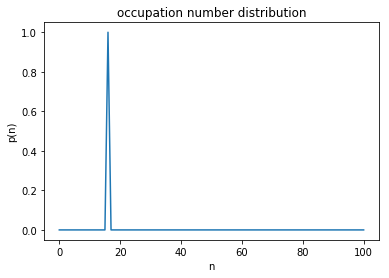

In [112]:
plt.plot(MD.BinCenters(nOcc_bin_edges),nOcc_hist)
plt.title("occupation number distribution")
plt.xlabel("n")
plt.ylabel("p(n)")

There is a single occupied bin, because all cells contain an equal number of particles.

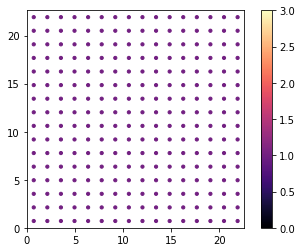

In [113]:
MD.PlotMDConf(x_tr[-1],y_tr[-1],xBox=(0,LBox),yBox=(0,LBox),xpbc=True,ypbc=True,m=m,c=m)

## The structure of a liquid

To test this for a liquid, we actually need to run a little simulation!

In [114]:
# define system
d=2
NParticles=256
kT = 1
m = np.ones(NParticles)
sigma = 1
epsilon = 1
#unit of time
tau = sigma*np.sqrt(m[0]/epsilon)      

# density
rho = 0.7/sigma**d
LBox = np.power(NParticles/rho,1/2)
print("LBox = ",LBox)

# define the length of the trajectory
run_time = 10 * tau
delta_t = tau / 100
number_of_timesteps = int(np.round(run_time/delta_t))


# to measure the computer time needed to calculate the ensemble of trajectory
initialWallTime = time.perf_counter()

# define initial state
x,y = MD.GridPositionsIn2d(LBox,LBox,NParticles)
vx = MD.RandomVelocities(m,kT)
vy = MD.RandomVelocities(m,kT)
t = 0

fx,fy = MD.LJ_forces_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y))
uPot = MD.LJ_energies_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y))
P = MD.LJ_virial_pressure_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y)) + MD.KineticPressure_as_a_function_of_velocities(2,LBox,m,(vx,vy))

#initialize Trajectory
t_tr = [t]
x_tr = [x]
vx_tr = [vx]
y_tr = [y]
vy_tr = [vy]
uPot_tr = [uPot]
P_tr = [P]

for timestep in range(number_of_timesteps):
    (x,y),(vx,vy) = MD.VelocityVerletTimeStepPartOne(m,(x,y),(vx,vy),(fx,fy),delta_t)
    fx,fy = MD.LJ_forces_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y))
    (x,y),(vx,vy) = MD.VelocityVerletTimeStepPartTwo(m,(x,y),(vx,vy),(fx,fy),delta_t)
    t += delta_t
    uPot = MD.LJ_energies_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y))
    P = MD.LJ_virial_pressure_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y)) + MD.KineticPressure_as_a_function_of_velocities(2,LBox,m,(vx,vy))

    t_tr.append(t)
    x_tr.append(x)
    vx_tr.append(vx)
    y_tr.append(y)
    vy_tr.append(vy)
    uPot_tr.append(uPot)   # do this at each time step, since routine is not (yet) suitable for analysing entire trajectories
    P_tr.append(P)
    
# convert trajectory lists to arrays to simplify the data analysis
t_tr = np.array(t_tr)
x_tr = np.array(x_tr)
vx_tr = np.array(vx_tr)
y_tr = np.array(y_tr)
vy_tr = np.array(vy_tr)
uPot_tr = np.array(uPot_tr)
P_tr = np.array(P_tr)

# analyse results 
uKin_tr = MD.ParticleKineticEnergies(m,vx_tr) + MD.ParticleKineticEnergies(m,vy_tr)
u_tr = np.sum(uKin_tr,axis=-1) + np.sum(uPot_tr,axis=-1)/2
        
print("Execution time: ",time.perf_counter() - initialWallTime)

LBox =  19.1236577494
Execution time:  31.49463480198756


In [115]:
y_tr.shape

(1001, 256)

In [116]:
nOcc_tr = CellOccupancy(4,x_tr,y_tr,LBox,LBox,x_pbc=True,y_pbc=True,debug=False)

nOcc_hist, nOcc_bin_edges = np.histogram(nOcc_tr, 101, (-0.5,100.5), normed=None, weights=None, density=True)

Text(0, 0.5, 'p(n)')

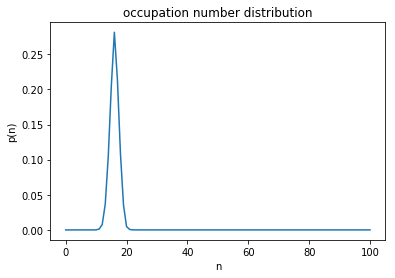

In [117]:
plt.plot(MD.BinCenters(nOcc_bin_edges),nOcc_hist)
plt.title("occupation number distribution")
plt.xlabel("n")
plt.ylabel("p(n)")

Again we have a very narrow peak, because a liquid is nearly incompressible.

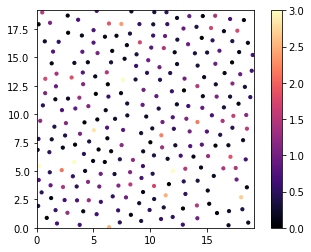

In [118]:
MD.PlotMDConf(x_tr[-1],y_tr[-1],xBox=(0,LBox),yBox=(0,LBox),xpbc=True,ypbc=True,m=m,c=uKin_tr[-1])

## To do

Formalize the relation between the fluctuations in the occupation number and the compressibility.